In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import yfinance as yf
import pandas as pd
from statsmodels.tsa.stattools import coint
from tqdm import tqdm

Duplicate key in file WindowsPath('d:/source/Anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 258 ('font.family:  Microsoft JhengHei')


In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'
warnings.filterwarnings("ignore")

In [ ]:
# 獲取數據
df_NQTXF = pd.read_parquet("datas/混合NQTXF.pqt", engine="fastparquet")
# 提取Close_TXF和Close_NQ列
stock1 = df_NQTXF["Close_TXF"]
stock2 = df_NQTXF["Close_NQ"]

# # 計算每月的比例
# monthly_ratio = stock1.resample("D").mean() / stock2.resample("D").mean()
# 設定重置時間
monthly_ratio = (
    # stock1.resample("M", offset="15H").first()
    stock1.resample("D", offset="0H").first()
    - stock2.resample("D", offset="0H").first()
)

# 將比例應用到每日數據
monthly_ratio = monthly_ratio.reindex(stock1.index, method="ffill")

# 調整股票價格
adjusted_stock1 = stock1 - monthly_ratio  # / monthly_ratio

# 計算調整後的spread
adjusted_spread = adjusted_stock1 - stock2

df = pd.DataFrame(adjusted_spread, columns=["adjusted_spread"])
df.to_parquet("datas/混合NQTXF的價差-時間關係_1比1.pqt")


# Round the adjusted_spread to integers
df["adjusted_spread"] = (df["adjusted_spread"] / 1).round().astype(int) * 1

# Filter the DataFrame for the time range from 15:00:00 to 09:00:00 of the next day
# 去除 13:30 ~ 13:45 的交易
initialing_start_time = "15:00:00"
initialing_end_time = "13:30:00"
df_filtered = df.between_time(initialing_start_time, initialing_end_time)

# Count the occurrences of each rounded adjusted_spread value for each time
df_filtered["Time"] = df_filtered.index.time
result = df_filtered.groupby(["Time", "adjusted_spread"]).size().unstack(fill_value=0)

# Create a new index with the desired order of times
new_index = pd.date_range(
    start="2022-08-22 15:00:00", end="2022-08-23 13:30:00", freq="10min"
).time

# Reindex the DataFrame with this new index
result = result.reindex(new_index)
# result就是每天的這個時間點 出現過的價差次數

# Function to expand the DataFrame
def expand_row(row):
    expanded = []
    for spread, count in row.items():
        if spread not in ['Time','adjusted_spread'] :
            count = 0 if pd.isna(count) else int(count)
            expanded.extend([int(spread)] * count)
    return expanded

# Expand the DataFrame
expanded_data = []
for index, row in result.iterrows():
    expanded_data.append(expand_row(row))

# Calculate mean and standard deviation
spread_std_dev=[]
spread_mean = []
spread_mean.extend(np.mean(i) for i in expanded_data)
spread_std_dev.extend(np.std(i) for i in expanded_data)

# 用上面正確的部分來整合
統計結果_df=pd.DataFrame(result)
# 這裡是如何計算每個時間點的標準差和平均值

# 計算每個時間點的平均值
mean_values = spread_mean

# 計算每個時間點的標準差
std_values = spread_std_dev

# 將結果添加到 DataFrame 中
統計結果_df['mean'] = mean_values
統計結果_df['std'] = std_values

統計結果std_df=pd.DataFrame(統計結果_df["std"])
統計結果std_df=統計結果std_df.reset_index()

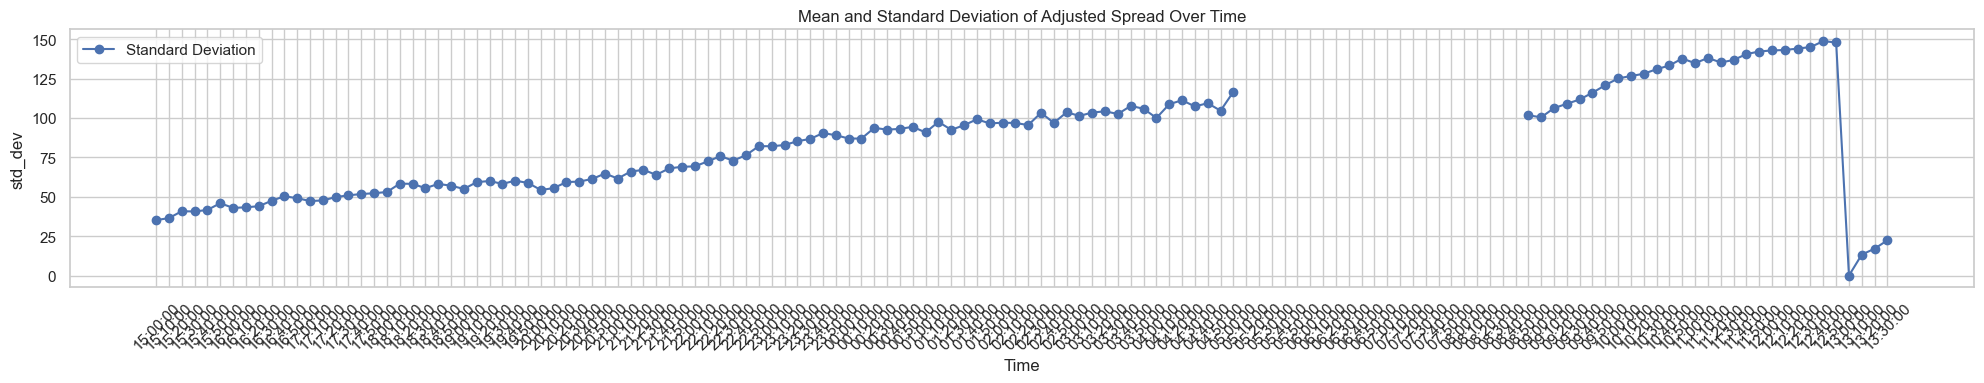

In [ ]:
# 設置圖表風格
sns.set(style="whitegrid")

# 繪製spread圖表
plt.figure(figsize=(20, 4))

# 繪製標準差
plt.plot(統計結果_df.index.astype(str), 統計結果_df['std'], marker='o', label='Standard Deviation')

# 添加標題和標籤
plt.title('Mean and Standard Deviation of Adjusted Spread Over Time')
plt.xlabel('Time')
plt.ylabel('std_dev')
plt.legend()

# 顯示圖形
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

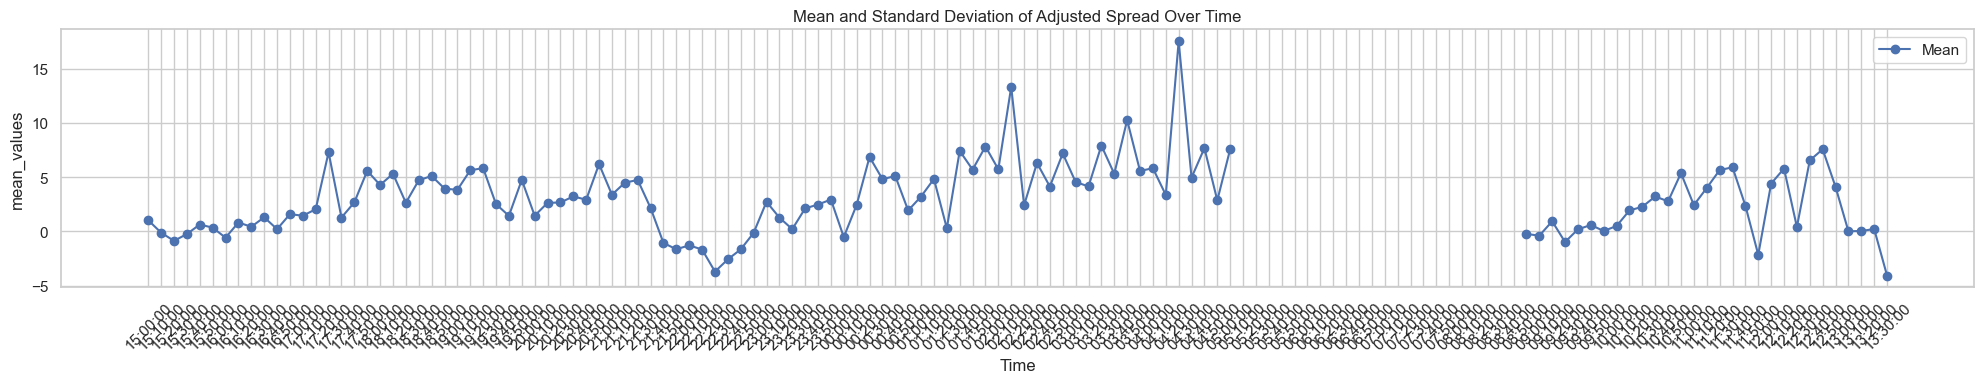

In [ ]:
# 設置圖表風格
sns.set(style="whitegrid")

# 繪製spread圖表
plt.figure(figsize=(20,4))

# 繪製平均值
plt.plot(統計結果_df.index.astype(str), 統計結果_df['mean'], marker='o', label='Mean')

# 添加標題和標籤
plt.title('Mean and Standard Deviation of Adjusted Spread Over Time')
plt.xlabel('Time')
plt.ylabel('mean_values')
plt.legend()

# 顯示圖形
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# 最後一步整合回測資料 方便回測
原始資料_df=pd.DataFrame(df)
原始資料_df.index = pd.to_datetime(原始資料_df.index)

# Filter the DataFrame to keep the index within the specified time range
initialing_start_time = "15:00:00"
initialing_end_time = "13:30:00"

# Create a mask to filter the DataFrame
mask = (原始資料_df.index.time >= pd.to_datetime(initialing_start_time).time()) | (原始資料_df.index.time <= pd.to_datetime(initialing_end_time).time())
原始資料_df = 原始資料_df[mask]

原始資料_df['Time']=原始資料_df.index.time
原始資料_df=原始資料_df.reset_index()


In [ ]:
# Merge the dataframes on the 'Time' column
merged_df = pd.merge(原始資料_df, 統計結果std_df, on='Time', how='left').ffill().bfill()
merged_df = merged_df.set_index('Datetime')

手動調整參數:
1. 重置時間
2. 

自動調整參數:
1. 進場std:0.5~3 區間,過大過小都不好
2. 收復多少std:0.5~3
3. 停損n點或n倍標準差:前者50~1000, 後者0.5~3
4. 可賺價差n點或進場std>n點:50~200
5. vix<n :10~25
6. 

參數漲跌比:
0.8~1.2 倍

回測預設條件 

In [19]:

# 預先計算時間閾值：將需要比較的時間閾值預先計算好，避免在迴圈中重複計算。
# initial 確保昨天的交易不會混入今天,是重置時間之後的3分鐘
initialing_start_time = pd.to_datetime('13:00:01').time()
initialing_end_time = pd.to_datetime('13:03:00').time()
# settle 強制結算時間
settle_start_time = pd.to_datetime('12:56:00').time()
settle_end_time = pd.to_datetime('13:00:00').time()
# trade 可交易時間 分兩段是因為有跨日
trade_start_time = pd.to_datetime('00:00:01').time()
trade_end_time = pd.to_datetime('12:55:00').time()
trade_start_time_2 = pd.to_datetime('03:03:01').time()
trade_end_time_2 = pd.to_datetime('23:59:59').time()

#VIX數據
vix_series = yf.download("^VIX", start="2018-01-01", end="2024-08-27")["Close"]
# 萬一row不一樣多的時候
vix_df = pd.DataFrame(vix_series)
# vix日期調整
vix_df = vix_df.reindex(merged_df.index, method="ffill")

[*********************100%%**********************]  1 of 1 completed


回測主體

In [39]:
# 初始化種群
# pop_size: 種群大小 較大的種群可以包含更多的基因組合，從而增加種群的多樣性，這有助於避免演算法陷入局部最優解
# gene_length: 基因長度（這裡是4，對應A, B, C, D）
def initialize_population(pop_size, gene_length):
    # 隨機生成範圍在[-10, 10]之間的實數種群
    # np.random.uniform(0, 20, size=(pop_size, gene_length))
    #  [4,4,0,0,0,2,0,60,3,12,5]
    # 基礎陣列
    base_array = np.array([20,1,0.7,100,100])
    # 生成偏移量，範圍在 -2 到 2 之間，形狀為 (pop_size, gene_length)
    offsets = np.random.uniform(0.5, 2, size=(pop_size, len(base_array)))
    # 生成新的陣列
    new_array = np.abs(base_array * offsets)
    new_array = np.round(new_array,1)
    return new_array


# 適應度函數 要被優化的東西 或者代表自然環境
# individual: 個體（包含A, B, C, D的值）
def fitness(individual):
    # [20,1,0.7,100,100]
    g_VIX門檻, g_進場std, g_收復std, g_可賺價差 , g_停損值 = individual
    # 計算適應度，這裡我們希望最小化函數值，因此取負數
    # 刪除VIX大於20的日資料
    merged_noVIX_df = merged_df[vix_df["Close"] <= g_VIX門檻]

    #進場時間條件
    # 向量化時間檢查：使用向量化操作來檢查每個時間點是否在特定的時間範圍內。
    times = merged_noVIX_df.index.time
    is_start_time = (times >= initialing_start_time) & (times <= initialing_end_time)
    is_settle_time = (times > settle_start_time) & (times < settle_end_time)
    is_trade_time = ((times >= trade_start_time) & (times <= trade_end_time)) | ((times >= trade_start_time_2) & (times <= trade_end_time_2))

    # 檢查今天是否是星期一到星期四 (週五晚上~週一的資料會莫名消失 所以用此方法閃避這個問題)
    weekdays = merged_noVIX_df.index.weekday
    is_trade_day = (weekdays >= 0) & (weekdays <= 3)  # 0: Monday, 1: Tuesday, 2: Wednesday, 3: Thursday

    # 初始化欄位：設定初始的 margin、stop_loss_triggered、position 和 pnl 欄位。
    merged_noVIX_df['margin'] = 0.0
    merged_noVIX_df['stop_loss_triggered'] = False
    merged_noVIX_df['position'] = 0
    merged_noVIX_df['pnl'] = 0

    #設定進場要幾倍標準差
    進場n倍_std=g_進場std

    #設定出場獲利要有幾倍標準差
    收復n倍_std=g_收復std
    手續費=3
    # 初始化變數：設定初始的 margin、position、entry_price、stop_loss_triggered 和 pnl 變數。
    margin = 0.0
    position = 0  # 1 表示多頭，-1 表示空頭，0 表示無持倉
    entry_price = 0.0
    stop_loss_triggered = False
    pnl = 0

    # 模擬配對交易：使用迴圈模擬配對交易，根據不同的時間段和條件來更新 margin、position 和 pnl。
    for i in range(1, len(merged_noVIX_df)):
        # 在新交易日開始時重置 stop_loss_triggered
        if is_start_time[i]: # 啟動時間
            stop_loss_triggered = False
            position = 0
        elif is_settle_time[i]: 
            # 結算時間
            if position != 0:
                pnl = (merged_noVIX_df.iloc[i]['adjusted_spread'] - entry_price) * position
                margin += (pnl-手續費)
                merged_noVIX_df.at[merged_noVIX_df.index[i], 'margin'] = margin
                position = 0
        elif is_trade_time[i] & is_trade_day[i]: 
            # 可交易時間
            if stop_loss_triggered: 
                # 當日止損過就別再交易
                continue

            else:
                if position == 0 and abs(merged_noVIX_df.iloc[i]['adjusted_spread']) > g_可賺價差:
                    # 最低可賺價差要>50
                    if merged_noVIX_df.iloc[i]['adjusted_spread'] > merged_noVIX_df.iloc[i]['std'] * 進場n倍_std: 
                        # 價差要大於n倍標準差
                        position = -1
                        entry_price = merged_noVIX_df.iloc[i]['adjusted_spread']
                    elif merged_noVIX_df.iloc[i]['adjusted_spread'] < -merged_noVIX_df.iloc[i]['std'] * 進場n倍_std: 
                        # 價差要大於n倍標準差
                        position = 1
                        entry_price = merged_noVIX_df.iloc[i]['adjusted_spread']
                elif position != 0: # 如果已經有開倉
                    pnl = (merged_noVIX_df.iloc[i]['adjusted_spread'] - entry_price) * position
                    if pnl <= (-1)*g_停損值: # 停損
                        margin += (pnl-手續費)
                        merged_noVIX_df.at[merged_noVIX_df.index[i], 'margin'] = margin
                        position = 0
                        stop_loss_triggered = True
                    elif pnl > merged_noVIX_df.iloc[i]['std'] * 收復n倍_std :#abs(entry_price): # 停利
                        margin += (pnl-手續費)
                        merged_noVIX_df.at[merged_noVIX_df.index[i], 'margin'] = margin
                        position = 0

        merged_noVIX_df.at[merged_noVIX_df.index[i], 'pnl'] = pnl
        merged_noVIX_df.at[merged_noVIX_df.index[i], 'position'] = position
        merged_noVIX_df.at[merged_noVIX_df.index[i], 'stop_loss_triggered'] = stop_loss_triggered

    # 延續 margin：使用 ffill 方法來延續 margin 欄位的值。這樣畫圖時，週六日就不會瞬間歸零
    merged_noVIX_df['margin'] = merged_noVIX_df['margin'].replace({0: np.nan})
    merged_noVIX_df['margin'] = merged_noVIX_df['margin'].ffill()

    #查看最終報酬
    try:
        earn_point = merged_noVIX_df.tail(1)['margin'].values[0]
        profit = earn_point #/ 3000
    except:
        profit = 0
    '''
    #計算MDD
    margin_history = merged_noVIX_df['margin'].values # array([  nan,   nan,   nan, ..., 1216., 1216., 1216.])
    # Remove NaN values
    cleaned_margin_history = margin_history[~np.isnan(margin_history)] + 3000 #保證金成本3000
    # Calculate the running maximum
    running_max = np.maximum.accumulate(cleaned_margin_history)
    # Calculate the drawdown
    drawdown = (cleaned_margin_history - running_max) / running_max
    # Find the maximum drawdown
    max_drawdown = drawdown.min()
    '''
    return round( profit)#(-100)*profit/max_drawdown,2)


# 計算每個元素的百分位數
def calculate_percentile(array, value):
    # 排序陣列
    sorted_array = np.sort(array)
    rank = np.searchsorted(sorted_array, value, side="right")
    percentile = (rank / len(array)) * 100
    return percentile


# 選擇函數
# population: 種群
# fitnesses: 每個個體的適應度
# 適應度高的個體更有可能被選中，但適應度低的個體也有一定的機會被選中
def selection(population, fitnesses):
    # total_fitness = max(fitnesses)
    # 計算每個個體被選中的概率
    # 計算每個個體被選中的概率
    # probabilities = [f / total_fitness for f in fitnesses]
    probabilities = [calculate_percentile(fitnesses, f) / 100 for f in fitnesses]
    # print("fitnesses=", fitnesses)
    # print("probabilities=", probabilities)
    # print()
    # 計算累積概率
    cumulative_probabilities = np.cumsum(probabilities)
    # 生成一個隨機數
    # 根據累積概率選擇個體
    while True:
        r = np.random.rand()
        for i, cumulative_probability in enumerate(cumulative_probabilities):
            if r < cumulative_probability:
                return population[i]
    '''
    # Step 1: probabilities = [f / total_fitness for f in fitnesses]
    probabilities = [calculate_percentile(fitnesses, f) / 100 for f in fitnesses]
    # Step 2: Normalize the linear values to range [0, 1]
    normalized_values = (probabilities - min(probabilities)) / (max(probabilities) - min(probabilities)
    # Step 3: Apply the exponential function
    a = 1  # Scaling factor
    b = 1  # Exponential growth rate
    exponential_values = a * np.exp(b * normalized_values)

    # Step 4: Scale the exponential values to range [1, 100]
    scaled_exponential_values = (exponential_values - min(exponential_values)) / (max(exponential_values) - min(exponential_values)) * 99 + 1

    # 計算累積概率 #我這次用的是純指數方法 而非累積概率方法
    # cumulative_probabilities = np.cumsum(probabilities)
    # 生成一個隨機數
    while True: 
        # 會生成一個r，如果抽到大於r的個體就會被挑出來 以防萬一所有人都陣亡 使用while true重新生成新的r
        # Generate a random number
        r = np.random.rand() * 100
        # Select individual based on scaled exponential values
        for i, cumulative_probability in enumerate(scaled_exponential_values):
            if r < cumulative_probability:
                return population[i]
    '''

# 交叉函數
# parent1, parent2: 父母個體
def crossover(parent1, parent2):
    # 隨機選擇交叉點
    point = np.random.randint(1, len(parent1))
    # 生成子代個體
    child1 = np.concatenate((parent1[:point], parent2[point:]))
    child2 = np.concatenate((parent2[:point], parent1[point:]))
    return child1, child2


# 變異函數
# individual: 個體
# mutation_rate: 變異率
def mutate(individual, mutation_rate):
    individual = np.abs(individual)
    individual = np.round(individual,1)
    for i in range(len(individual)):
        # 以變異率的概率對基因進行變異
        if np.random.rand() < mutation_rate:
            individual[i] += np.random.uniform(0.5, 2)
            # 生成一個範圍在-1到1之間的隨機數，並將這個隨機數加到當前基因的值上。這樣，基因的值會在一定範圍內隨機變化。
    individual = np.abs(individual)
    individual = np.round(individual,1)
    return individual


# 基因演算法主函數
# pop_size: 種群大小
# gene_length: 基因長度
# generations: 迭代次數
# mutation_rate: 變異率
def genetic_algorithm(pop_size, gene_length, generations, mutation_rate=0.8):
    # 初始化種群
    population = initialize_population(pop_size, gene_length)
    for generation in range(generations):
        # try:
            # 計算每個個體的適應度 準備下一輪的淘汰
            fitnesses = [fitness(ind) for ind in population]
            new_population = []
            for _ in range(pop_size // 2):
                # 選擇父母個體
                parent1 = selection(population, fitnesses)
                parent2 = selection(population, fitnesses)
                # 交叉生成子代
                child1, child2 = crossover(parent1, parent2)
                # 變異子代
                new_population.append(mutate(child1, mutation_rate))
                new_population.append(mutate(child2, mutation_rate))
            # 更新種群
            population = np.array(new_population)
            population = np.abs(new_population)
            population = np.round(new_population,1)
            # 找到當前代的最佳適應度和個體

            best_fitness = max(fitnesses)
            best_individual = population[np.argmax(fitnesses)]
            # print(np.round(np.argmax(fitnesses), 1))
            # print(np.round(best_individual), 1)
            # argmax回傳fitness陣列中，最大值的所在位置
            # 然後用population叫他們出列
            print(f"Generation {generation}: Best profit = {best_fitness}, Best Individual = {best_individual}"    )
        # except:
        #     pass
    return population

final_population = genetic_algorithm(pop_size=15, gene_length=5, generations=50)


Generation 0: Best profit = 2446, Best Individual = [ 41.2   3.    1.2 103.5 131.2]
Generation 1: Best profit = 2543, Best Individual = [ 42.6   1.3   1.2 103.8 130.2]
Generation 2: Best profit = 2827, Best Individual = [ 42.8   3.8   1.9 104.9 130.9]
Generation 3: Best profit = 2532, Best Individual = [ 41.5   4.4   1.2 104.2 133.2]
Generation 4: Best profit = 2525, Best Individual = [ 43.1   5.6   4.  105.8 131.2]
Generation 5: Best profit = 1337, Best Individual = [ 43.1   4.3   4.  107.4 133.6]
Generation 6: Best profit = 1465, Best Individual = [ 43.1   4.3   5.8 107.2 134.1]
Generation 7: Best profit = 1747, Best Individual = [ 43.7   7.    7.8 108.6 134.1]
Generation 8: Best profit = 1747, Best Individual = [ 43.1   6.4   6.9 108.2 135.9]
Generation 9: Best profit = 1705, Best Individual = [ 44.7   6.8   6.4 108.2 137.6]
Generation 10: Best profit = 1705, Best Individual = [ 44.7   6.    7.4 108.2 137.4]
Generation 11: Best profit = 1518, Best Individual = [ 48.2   5.7   7.7 108

KeyboardInterrupt: 

績效回報指令

In [11]:
#查看最終報酬
earn_point = merged_noVIX_df.tail(1)['margin'].values[0]
profit = earn_point / 3000
print(f"earn_point: {earn_point}")
print(f"profit: {profit * 100:.2f}%")

earn_point: 1376.0
profit: 45.87%


In [12]:
#計算MDD
margin_history = merged_noVIX_df['margin'].values # array([  nan,   nan,   nan, ..., 1216., 1216., 1216.])

# Remove NaN values
cleaned_margin_history = margin_history[~np.isnan(margin_history)] + 3000 #保證金成本3000

# Calculate the running maximum
running_max = np.maximum.accumulate(cleaned_margin_history)

# Calculate the drawdown
drawdown = (cleaned_margin_history - running_max) / running_max

# Find the maximum drawdown
max_drawdown = drawdown.min()

print(f"Maximum Drawdown: {max_drawdown * 100:.2f}%")

Maximum Drawdown: -16.53%


In [13]:
# 若要儲存回測報告
merged_noVIX_df.to_csv("datas/NQTXF-回測報告_標準差方法.csv")
#2023-01-01 ~ 2024-08-08 共606天 412個交易日

PermissionError: [Errno 13] Permission denied: 'datas/NQTXF-回測報告_標準差方法.csv'

繪圖

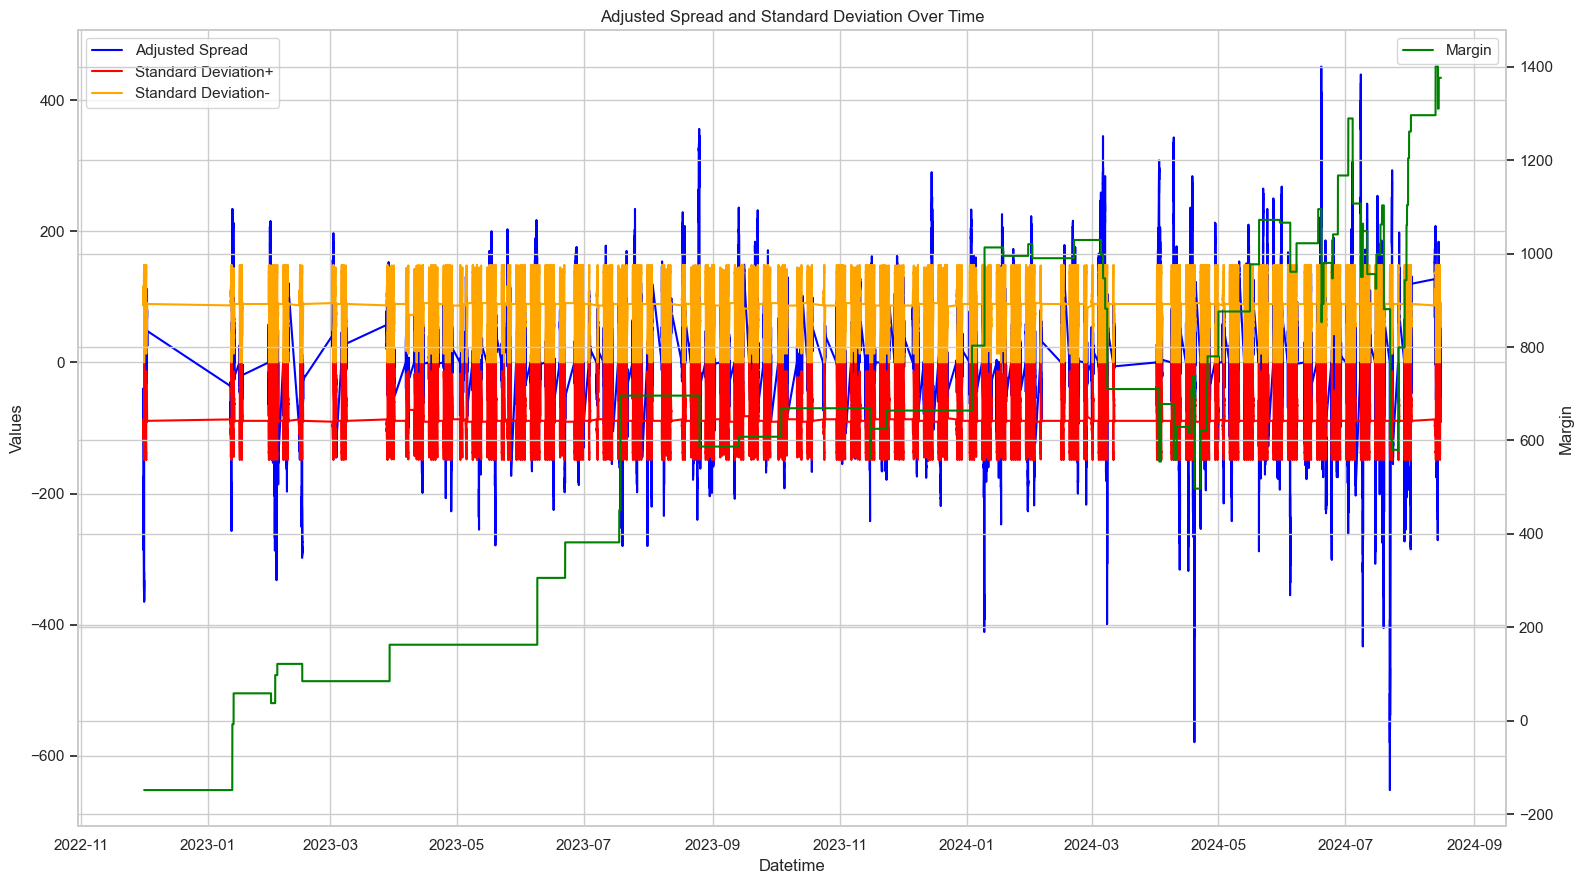

In [15]:
# 單圖
#interactive plotting in separate window
# %matplotlib qt 
%matplotlib inline 
# Assuming merged_df is already created
# merged_df = pd.read_csv('path_to_merged_df.csv')

# Set the 'Datetime' column as the index
# merged_df.set_index('Datetime', inplace=True)


# Creating the figure and the first subplot
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))
fig, ax1 = plt.subplots(1, 1, figsize=(16, 9))

# Plotting the first set of data
ax1.plot(merged_noVIX_df.index, merged_noVIX_df['adjusted_spread'], label='Adjusted Spread', color='blue')
ax1.plot(merged_noVIX_df.index, merged_noVIX_df['std']*(-1), label='Standard Deviation+', color='red')
ax1.plot(merged_noVIX_df.index, merged_noVIX_df['std'], label='Standard Deviation-', color='orange')

# Adding titles and labels to the first plot
ax1.set_title('Adjusted Spread and Standard Deviation Over Time')
ax1.set_xlabel('Datetime')
ax1.set_ylabel('Values')
ax1.legend()

# Creating a second y-axis for the 'margin' data
ax2 = ax1.twinx()
ax2.plot(merged_noVIX_df.index, merged_noVIX_df['margin'], label='Margin', color='green')

# Adding labels to the second y-axis
ax2.set_ylabel('Margin')
ax2.legend(loc='upper right')


plt.grid(True)


# Adjusting layout and displaying the plots
plt.tight_layout()
plt.show()

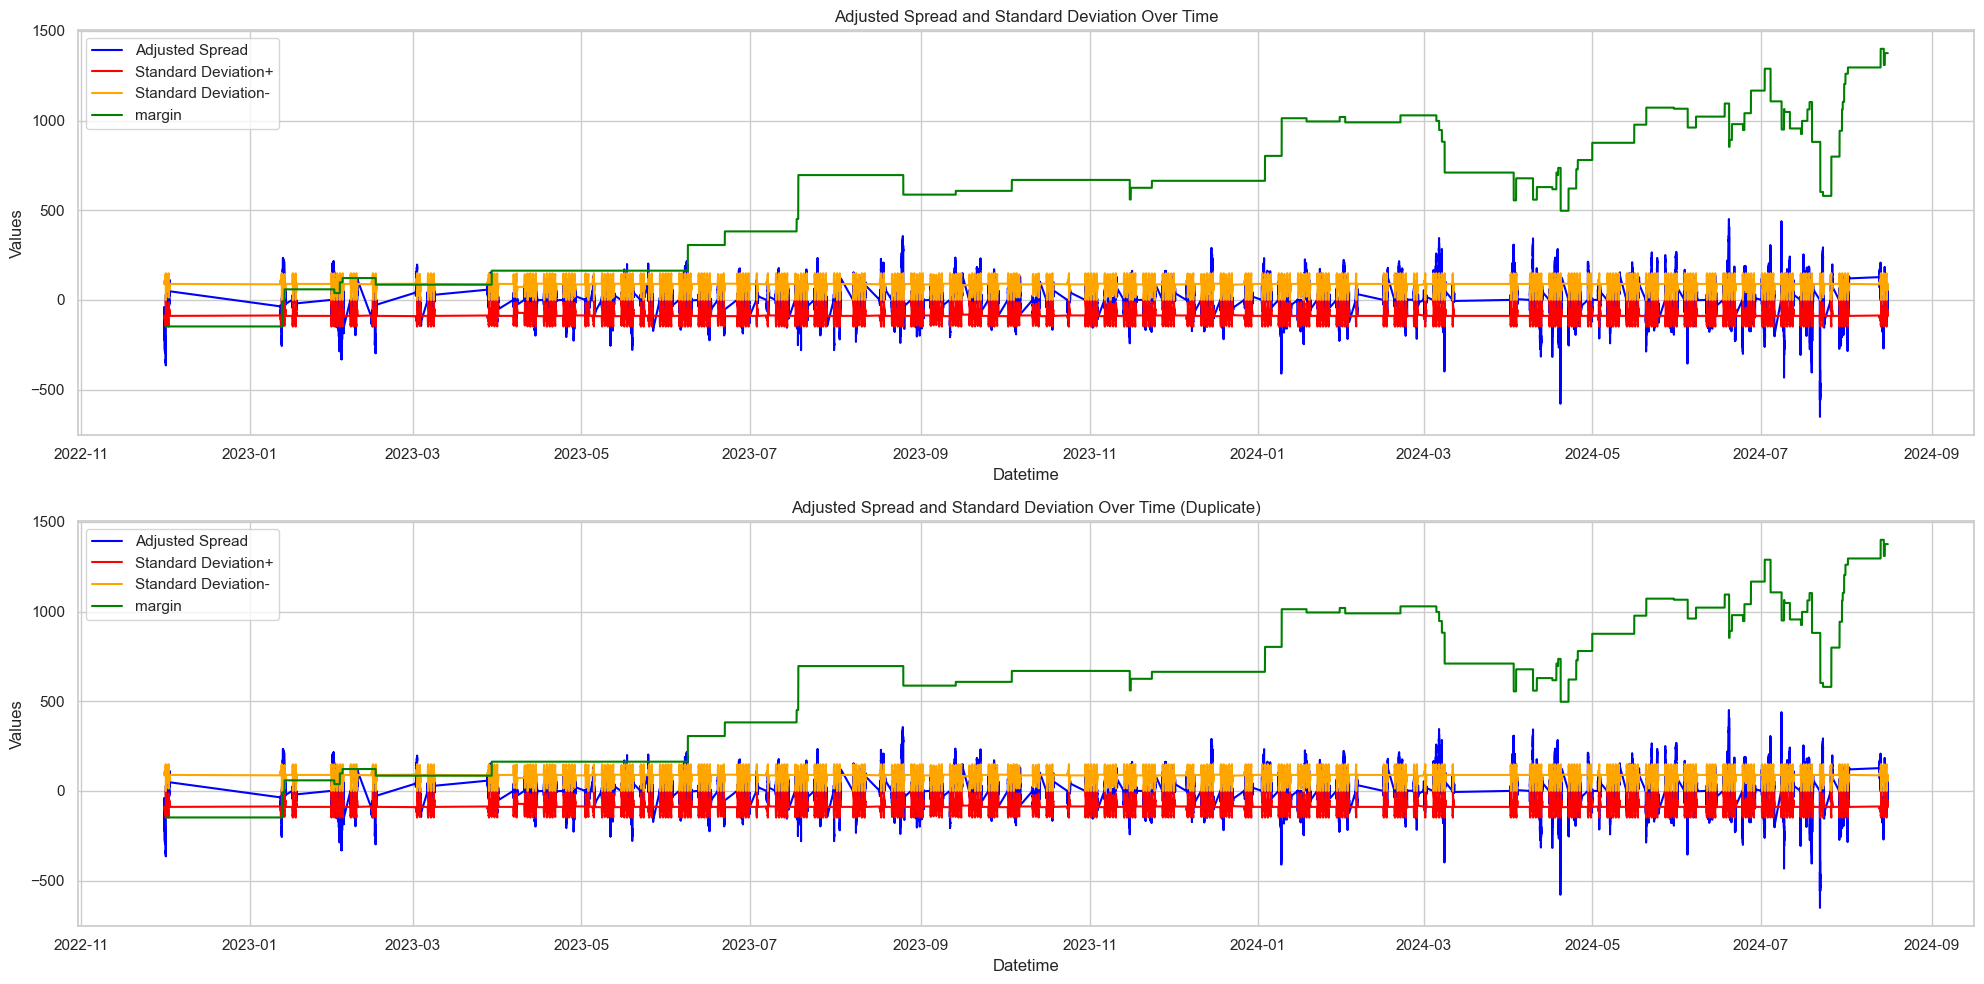

In [16]:
# 雙圖
#interactive plotting in separate window
# %matplotlib qt 
%matplotlib inline 
# Assuming merged_df is already created
# merged_df = pd.read_csv('path_to_merged_df.csv')

# Set the 'Datetime' column as the index
# merged_df.set_index('Datetime', inplace=True)


# Creating the figure and the first subplot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))

# Plotting the first set of data
ax1.plot(merged_noVIX_df.index, merged_noVIX_df['adjusted_spread'], label='Adjusted Spread', color='blue')
ax1.plot(merged_noVIX_df.index, merged_noVIX_df['std']*(-1), label='Standard Deviation+', color='red')
ax1.plot(merged_noVIX_df.index, merged_noVIX_df['std'], label='Standard Deviation-', color='orange')
ax1.plot(merged_noVIX_df.index, merged_noVIX_df['margin'], label='margin', color='green')

# Adding titles and labels to the first plot
ax1.set_title('Adjusted Spread and Standard Deviation Over Time')
ax1.set_xlabel('Datetime')
ax1.set_ylabel('Values')
ax1.legend()
plt.grid(True)

# Plotting the second set of data (same as the first for demonstration)
ax2.plot(merged_noVIX_df.index, merged_noVIX_df['adjusted_spread'], label='Adjusted Spread', color='blue')
ax2.plot(merged_noVIX_df.index, merged_noVIX_df['std']*(-1), label='Standard Deviation+', color='red')
ax2.plot(merged_noVIX_df.index, merged_noVIX_df['std'], label='Standard Deviation-', color='orange')
ax2.plot(merged_noVIX_df.index, merged_noVIX_df['margin'], label='margin', color='green')

# Adding titles and labels to the second plot
ax2.set_title('Adjusted Spread and Standard Deviation Over Time (Duplicate)')
ax2.set_xlabel('Datetime')
ax2.set_ylabel('Values')
ax2.legend()
plt.grid(True)


# Adjusting layout and displaying the plots
plt.tight_layout()
plt.show()